In [1]:
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import  Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from tensorflow.keras.preprocessing import image
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_W = 224
IMAGE_H = 224

In [4]:
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    # Tao model
    input = Input(shape=(IMAGE_W, IMAGE_H, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='sigmoid', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])

    return my_model

model = get_model()

58889256/58889256 [==============================] - 4s 0us/step


In [6]:
csv_file = "/content/drive/MyDrive/NLP/miml_dataset/miml_labels_1.csv"
image_path ="/content/drive/MyDrive/NLP/miml_dataset/images"

train = pd.read_csv(csv_file)
train.head(5)

,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0
2,3.jpg,1,0,0,0,0
3,4.jpg,1,1,0,0,0
4,5.jpg,1,0,0,0,0


In [7]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size // self.batch_size

class Dataset:
    def __init__(self, data, label, w, h):
        # the paths of images
        self.data = data
        # the paths of segmentation images
        self.label = label
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # read data
        img = image.load_img(image_path + '/' + str(self.data[i][0]),target_size=(IMAGE_W,IMAGE_H,3))
        img = image.img_to_array(img)
        img = img /255
        label = self.label[i]
        return img, label

In [8]:
y = np.array(train.drop(columns=["Filenames"]))
X = np.array(train)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


In [10]:
# Xay dung dataset va Dataloader
# Build dataaset
train_dataset = Dataset(X_train, y_train, IMAGE_W, IMAGE_H)
test_dataset = Dataset(X_test, y_test, IMAGE_W, IMAGE_H)

# Loader

train_loader = Dataloader(train_dataset, 64, len(train_dataset))
test_loader = Dataloader(test_dataset, 64, len(test_dataset))

In [11]:
model.fit(train_loader, epochs=10, validation_data=test_loader)

Epoch 1/10
28/28 [==============================] - 1268s 45s/step - loss: 1.3326 - binary_accuracy: 0.7425 - val_loss: 0.3436 - val_binary_accuracy: 0.8552
Epoch 2/10
28/28 [==============================] - 11s 394ms/step - loss: 0.3343 - binary_accuracy: 0.8522 - val_loss: 0.2783 - val_binary_accuracy: 0.8958
Epoch 3/10
28/28 [==============================] - 11s 387ms/step - loss: 0.2657 - binary_accuracy: 0.8842 - val_loss: 0.2385 - val_binary_accuracy: 0.8979
Epoch 4/10
28/28 [==============================] - 11s 399ms/step - loss: 0.2182 - binary_accuracy: 0.9109 - val_loss: 0.2455 - val_binary_accuracy: 0.8938
Epoch 5/10
28/28 [==============================] - 11s 403ms/step - loss: 0.1953 - binary_accuracy: 0.9194 - val_loss: 0.2600 - val_binary_accuracy: 0.8927
Epoch 6/10
28/28 [==============================] - 11s 371ms/step - loss: 0.1808 - binary_accuracy: 0.9247 - val_loss: 0.2457 - val_binary_accuracy: 0.9125
Epoch 7/10
28/28 [==============================] - 11s 40

In [20]:
model.save('/content/drive/MyDrive/NLP/Multi_LabelClassification1.keras')

In [13]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/NLP/Multi_LabelClassification1.keras")

In [21]:
print(model.evaluate(test_loader))

3/3 [==============================] - 1s 360ms/step - loss: 0.2430 - binary_accuracy: 0.9104
[0.2430042028427124, 0.9104166626930237]


In [22]:
img = image.load_img("/content/drive/MyDrive/NLP/miml_dataset/images/99.jpg", target_size=(IMAGE_W,IMAGE_H,3))
img = image.img_to_array(img)
img = img/255

tensor = np.expand_dims(img, axis=0)

In [23]:
y_pred = model.predict(tensor)
y_pred

1/1 [==============================] - 0s 21ms/step


array([[9.8842096e-01, 1.9212296e-02, 3.5661247e-03, 9.0022695e-06,
        3.6007253e-04]], dtype=float32)

In [24]:
classes = np.array(train.columns[1:])

top_3 = np.argsort(y_pred[0])[:-4:-1]
top_3

array([0, 1, 2])

In [25]:
classes = np.array(train.columns[1:])

top_3 = np.argsort(y_pred[0])[:-4:-1]
top_3

array([0, 1, 2])

desert (0.988)
mountains (0.0192)
sea (0.00357)


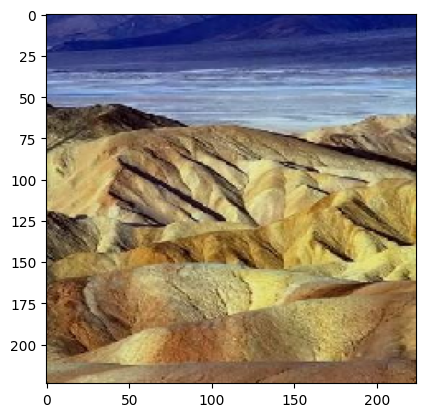

In [26]:
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(y_pred[0][top_3[i]]))
plt.imshow(img)

In [ ]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

In [ ]:
classes = ['desert',	'mountains',	'sea',	'sunset',	'trees']

